# Síntesis de instrumentos
**Procesamiento de señales**



---

## Introducción
Cuando un instrumento produce una nota, además de la frecuencia fundamental, también se producen múltiples frecuencias armónicas que son múltiplos enteros de la frecuencia fundamental. La amplitud relativa de estos armónicos son lo que da a cada instrumento su carácter sonoro único, conocido como timbre.
<br>
<br>
Para poder recrear artificialmente y de manera convincente el timbre de un instrumento en particular, es necesario extraer y reproducir el contenido armónico de las notas del instrumento.
<br>
<br>
En este trabajo, describiremos el proceso de extracción de armónicos de las grabaciones de un violín y la síntesis de nuevas notas a partir de estos armónicos. El objetivo es producir notas sintetizadas que suenen lo más parecido posible al violín original. En el camino, también exploraremos conceptos relacionados, como la envolvente ADSR, que se utiliza para modelar el ataque, el decaimiento, el sostenimiento y la relajación o desvanecimiento de la nota, características que también contribuyen al timbre final del sonido producido.  


---



El primer paso consiste en importar las librerías necesarias y crear una función que se ocupará de cargar el archivo de audio y extraer la señal y la frecuencia de muestreo.

In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import argrelmax
from scipy.io.wavfile import write

notas = ['a4', 'c4', 'g4']

def importar_archivo(filepath):
    # Importa el archivo .wav
    freq_muestreo, s_t = wav.read(filepath)

    # Calcula el tiempo correspondiente a cada muestra de la señal
    duracion = len(s_t) / freq_muestreo
    t = np.linspace(0, duracion, len(s_t))

    return freq_muestreo, s_t, t

freq_muestreo = {}
s_t = {}
t = {}

for n in notas:
  freq_muestreo[n], s_t[n], t[n] = importar_archivo(f'violin-{n}.wav')

Graficamos las señales importadas:

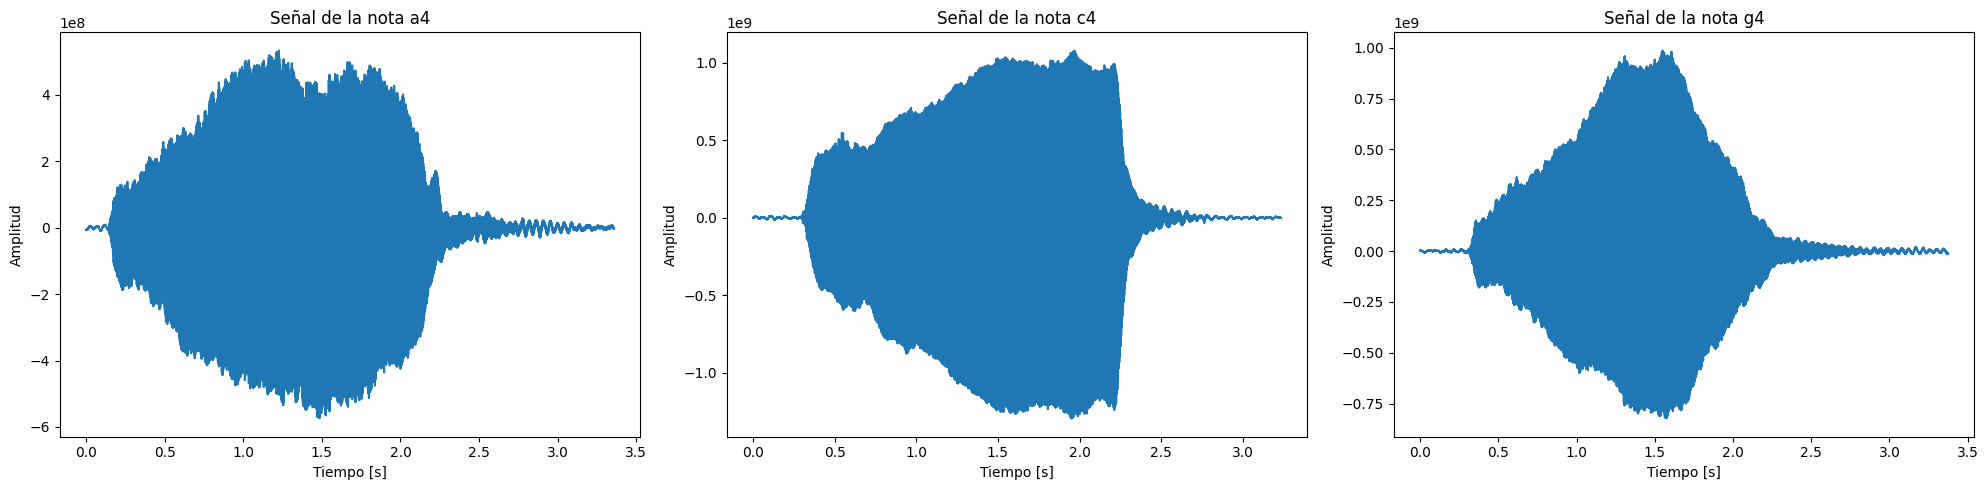

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].plot(t[nota], s_t[nota])
    axs[i].set_title(f'Señal de la nota {nota}')
    axs[i].set_xlabel('Tiempo [s]')
    axs[i].set_ylabel('Amplitud')

plt.tight_layout()
plt.show()



---

Creamos una función que calcula la FFT de la señal y obtiene las frecuencias, con sus respectivas amplitudes y fases.

Luego realizamos los gráficos de espectro de frecuencias para cada nota

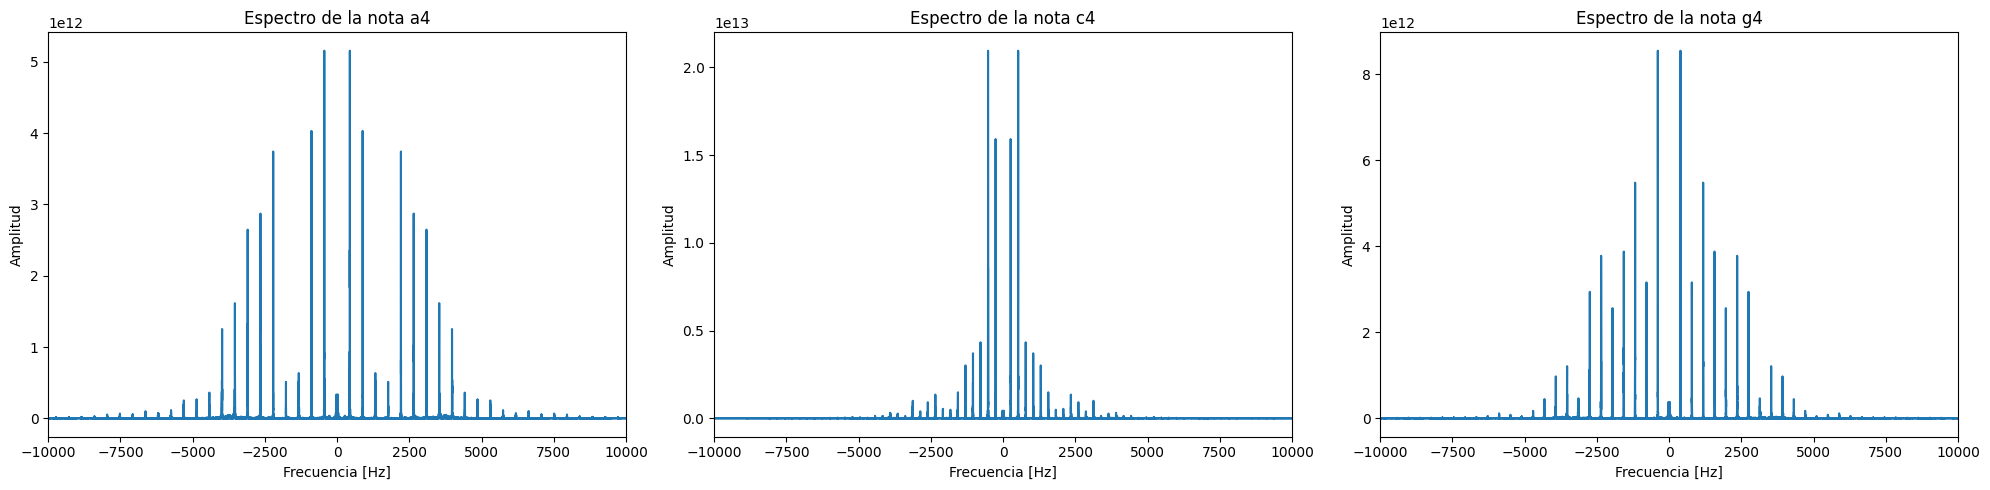

In [3]:
def calcular_fft(s_t, t):
    # Calcula la transformada de Fourier de la señal
    S_w = np.fft.fft(s_t)

    # Calcula módulo y fase de S(w)
    modulo_S_w = np.abs(S_w)
    fase_S_w = np.angle(S_w)

    # Calcula la frecuencia para cada componente en S_w
    frecuencias = np.fft.fftfreq(len(s_t), d=t[1] - t[0])

    return frecuencias, modulo_S_w, fase_S_w

frecuencias_S = {}
modulo_S_w = {}
fase_S_w = {}

for n in notas:
  frecuencias_S[n], modulo_S_w[n], fase_S_w[n] = calcular_fft(s_t[n], t[n])


#Grafico los espectros de frecuencia:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].plot(frecuencias_S[nota], modulo_S_w[nota])
    axs[i].set_title(f'Espectro de la nota {nota}')
    axs[i].set_xlabel('Frecuencia [Hz]')
    axs[i].set_ylabel('Amplitud')

    # Ajusta el rango de frecuencias mostrado
    axs[i].set_xlim([-10000, 10000])

plt.tight_layout()
plt.show()



---

Una vez obtenidas las frecuencias que componen la señal de cada nota, podemos utilizar la función *argrelmax* de la librería Scipy para identificar los picos en el espectro de amplitud, los cuales corresponden a los armónicos más relevantes de la señal.
<br>
<br>
Posteriormente, ordenamos estos armónicos en función de su amplitud, de mayor a menor, y seleccionamos los primeros N armónicos. Estos son los que más contribuyen al perfil sonoro de la señal. En este caso, hemos elegido considerar los 40 armónicos de mayor amplitud.

In [4]:
def filtrar_armonicos(frecuencias, modulo_S_w, fase_S_w, N):
    # Sólo considera la mitad positiva del espectro
    frecuencias = frecuencias[:len(frecuencias)//2]
    modulo_S_w = modulo_S_w[:len(modulo_S_w)//2]
    fase_S_w = fase_S_w[:len(fase_S_w)//2]

    # Encuentra los índices de todos los máximos locales
    indices_maximos = argrelmax(modulo_S_w)

    # Extrae las amplitudes y fases de estos máximos
    amplitudes_maximos = modulo_S_w[indices_maximos]
    fases_maximos = fase_S_w[indices_maximos]

    # Extrae las frecuencias de estos máximos
    frecuencias_maximos = frecuencias[indices_maximos]

    # Encuentra los índices que ordenarían las amplitudes de mayor a menor
    indices_ordenados = np.argsort(amplitudes_maximos)[::-1]

    # Ordena las amplitudes y frecuencias
    amplitudes_maximos = amplitudes_maximos[indices_ordenados]
    fases_maximos = fases_maximos[indices_ordenados]
    frecuencias_maximos = frecuencias_maximos[indices_ordenados]

    # Selecciona los N armónicos de mayor amplitud
    if len(amplitudes_maximos) > N:
        amplitudes_maximos = amplitudes_maximos[:N]
        fases_maximos = fases_maximos[:N]
        frecuencias_maximos = frecuencias_maximos[:N]

    return frecuencias_maximos, amplitudes_maximos, fases_maximos

frecuencias = {}
amplitudes = {}
fases = {}

for n in notas:
  frecuencias[n], amplitudes[n], fases[n] = filtrar_armonicos(frecuencias_S[n], modulo_S_w[n], fase_S_w[n], 40)

Graficamos las frecuencias y fases más relevantes obtenidas en el proceso anterior:

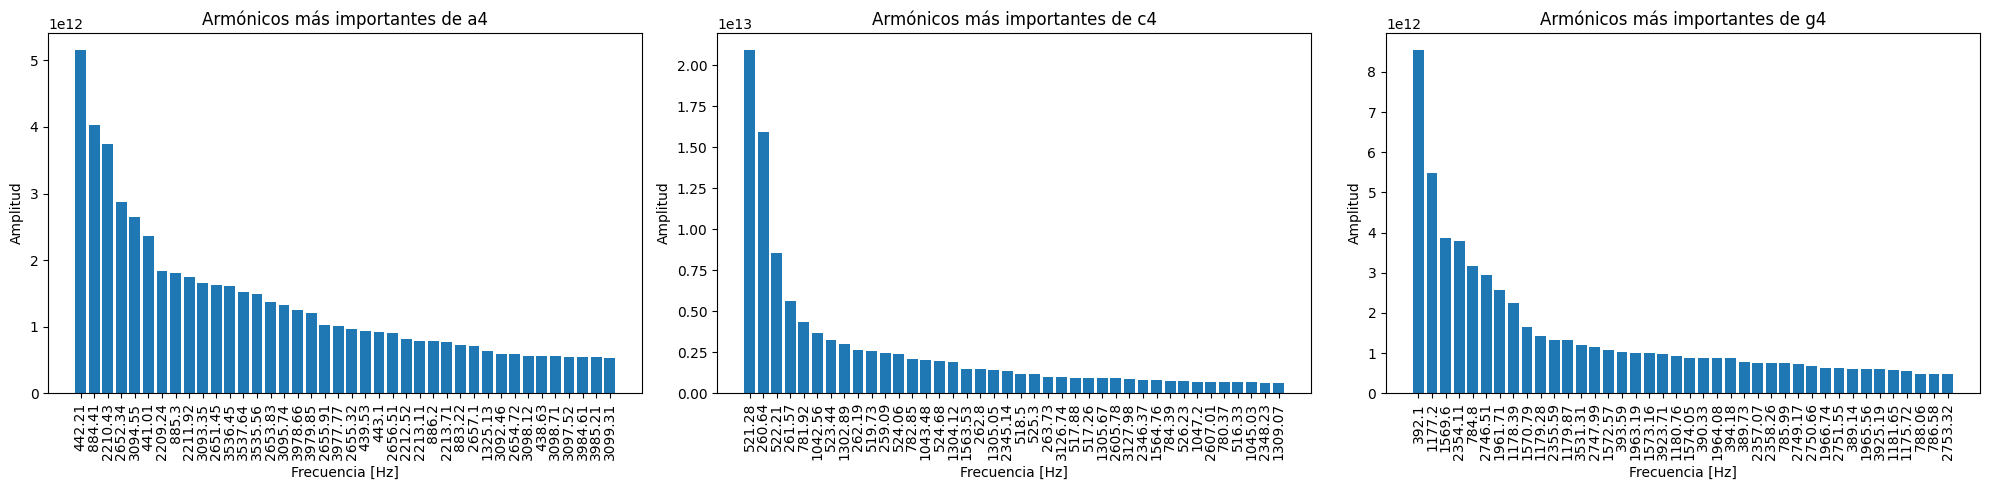

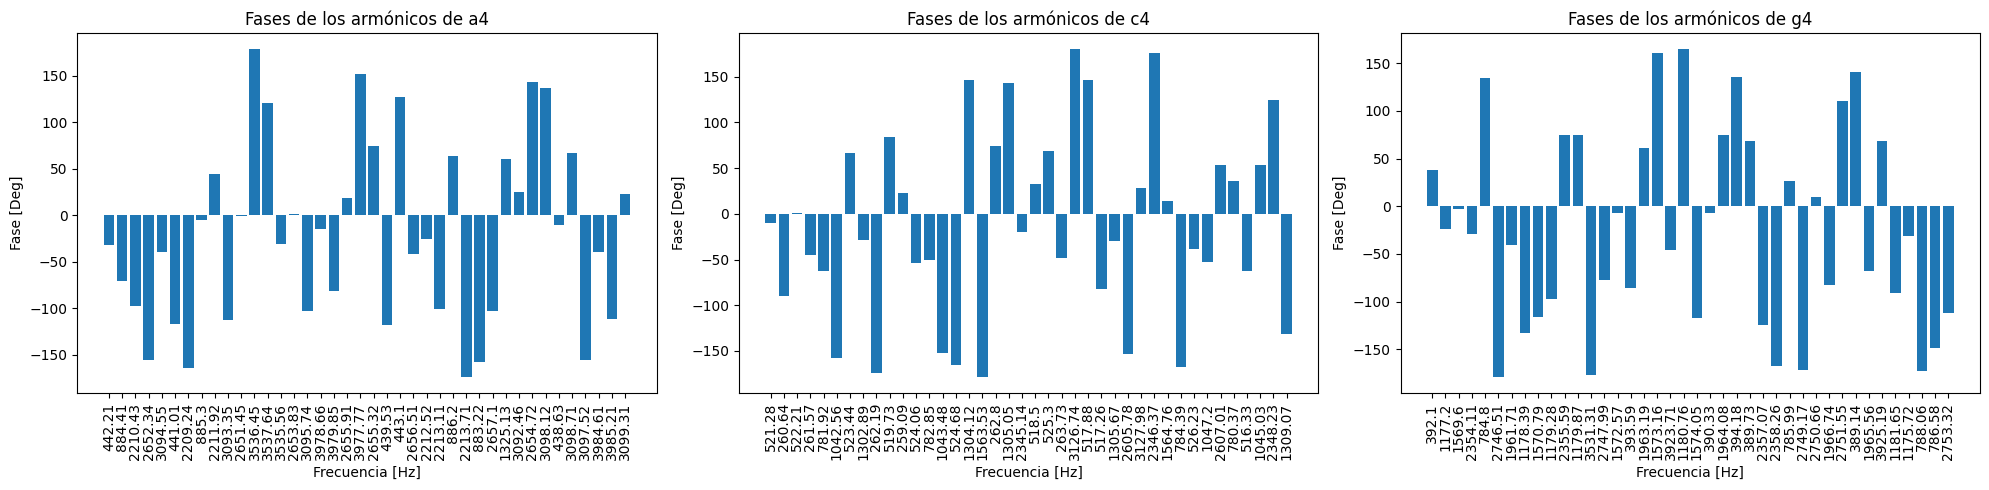

In [5]:
#Gráfico de frecuencias
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].bar(range(len(frecuencias[nota])), amplitudes[nota])
    axs[i].set_xticks(range(len(frecuencias[nota])))
    axs[i].set_xticklabels(np.round(frecuencias[nota], 2), rotation='vertical')
    axs[i].set_title(f'Armónicos más importantes de {nota}')
    axs[i].set_xlabel('Frecuencia [Hz]')
    axs[i].set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

#Grafico de fases
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].bar(range(len(frecuencias[nota])), np.rad2deg(fases[nota]))
    axs[i].set_xticks(range(len(frecuencias[nota])))
    axs[i].set_xticklabels(np.round(frecuencias[nota], 2), rotation='vertical')
    axs[i].set_title(f'Fases de los armónicos de {nota}')
    axs[i].set_xlabel('Frecuencia [Hz]')
    axs[i].set_ylabel('Fase [Deg]')

plt.tight_layout()
plt.show()

Una vez obtenidas las frecuencias de los armónicos más importantes de cada señal, con las amplitudes y fases correspondientes, podemos generar las nuevas señales:

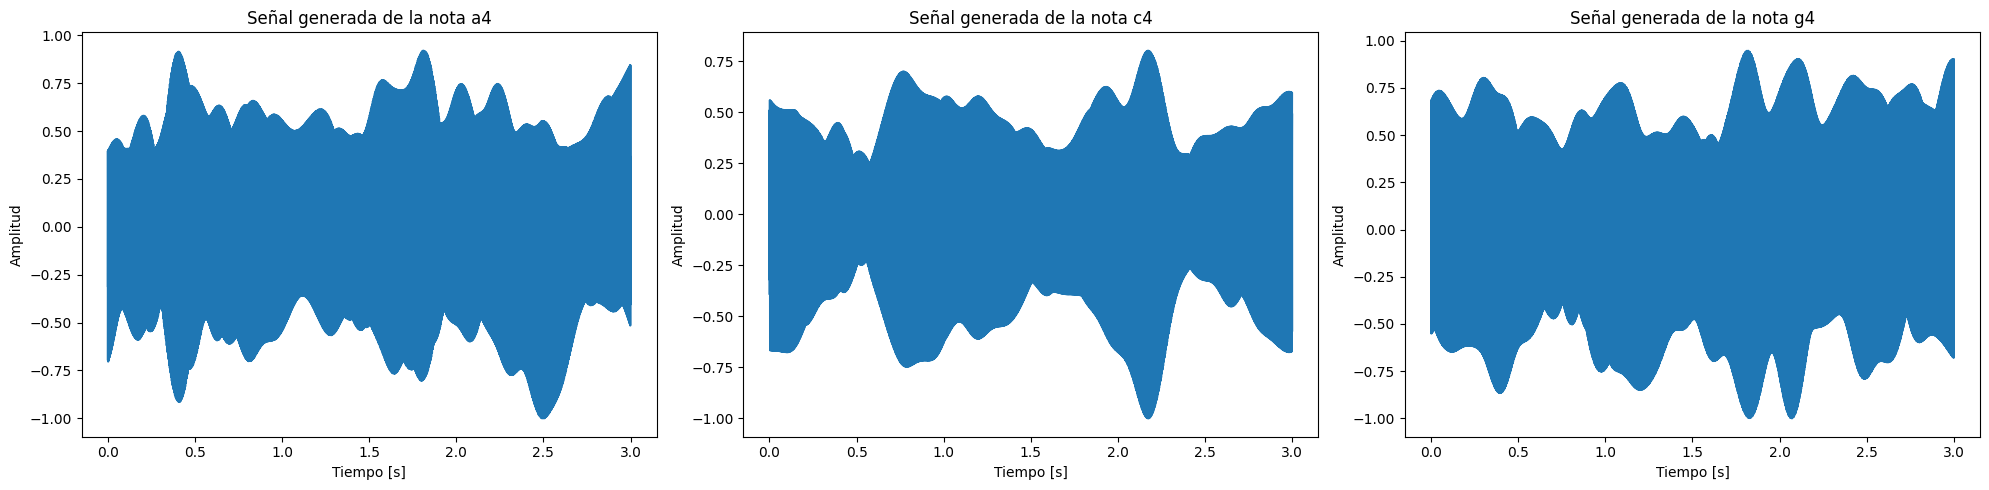

In [6]:
def generar_señal(freq_muestreo, duracion, frequencias, amplitudes, fases):
    t = np.linspace(0, duracion, freq_muestreo * int(duracion))
    signal = np.zeros(int(freq_muestreo * duracion))
    for frequencia, amplitud, fase in zip(frequencias, amplitudes, fases):
        signal += amplitud * np.sin(2 * np.pi * np.arange(freq_muestreo * duracion) * frequencia / freq_muestreo + fase)

    # Nos aseguramos de que la señal esté en el rango de -1 a 1
    signal = signal / np.max(np.abs(signal))
    return signal, t

signal = {}
t = {}
duracion = 3.0

for n in notas:
  signal[n], t[n] = generar_señal(freq_muestreo[n], duracion, frecuencias[n], amplitudes[n], fases[n])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].plot(t[nota], signal[nota])
    axs[i].set_title(f'Señal generada de la nota {nota}')
    axs[i].set_xlabel('Tiempo [s]')
    axs[i].set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

Como podemos observar en los gráficos, a diferencia de las señales originales, las generadas artificialmente empiezan y terminan de forma abrupta. Para suavizarlas, podríamos aplicar, por ejemplo, un ventaneo Hamming.
<br>
<br>
Pero en un instrumento real, el sonido tiene una evolución característica en el tiempo: Empieza suavemente (ataque), alcanza un pico y luego disminuye (decaimiento), se sostiene a un nivel constante por un tiempo (sostenimiento) y finalmente decae hasta silenciarse (relajación o desvanecimiento). A esta evolución característica se la conoce como envolvente ADSR.
<br>
<br>
La aplicación de una envolvente ADSR a una señal generada artificialmente reproduce estas características, dándole a la señal un sonido más realista y musical.
<br>
<br>
Generamos a continuación una envolvente que ajustamos para reproducir lo más fielmente posible a la característica de un violín.

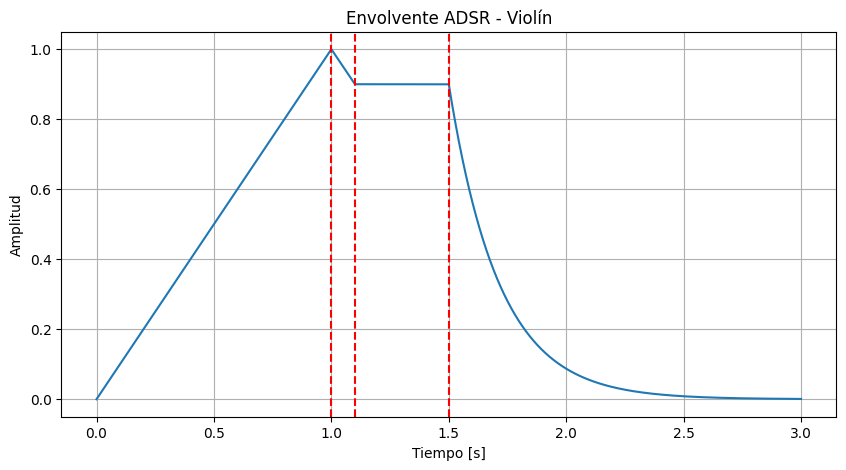

In [7]:
def crear_envolvente_adsr(A, D, nivel_S, R, duracion, freq_muestreo):
    # Calcular el número de muestras para cada segmento
    A_samples = int(A * freq_muestreo)
    D_samples = int(D * freq_muestreo)
    R_samples = int(R * freq_muestreo)

    # El número de muestras de sostenimiento es el restante
    S_samples = int(duracion * freq_muestreo) - (A_samples + D_samples + R_samples)

    if S_samples < 0:
        raise ValueError('La duración total es demasiado corta para los valores ADSR proporcionados')

    # Crear cada segmento de la envolvente ADSR
    A_segment = np.linspace(0, 1, A_samples)
    D_segment = np.linspace(1, nivel_S, D_samples)
    S_segment = nivel_S * np.ones(S_samples)

    # Crear el segmento R como una exponencial decreciente
    t = np.linspace(0, R, R_samples)
    R_segment = nivel_S * np.exp(-7 * t / R)

    # Concatenar los segmentos para obtener la envolvente completa
    envelope = np.concatenate((A_segment, D_segment, S_segment, R_segment))

    return envelope


envolvente = crear_envolvente_adsr(1, 0.1, 0.9, 1.5, duracion, freq_muestreo['a4'])

t = np.linspace(0, duracion, len(envolvente))

# Crear el gráfico de la envolvente
plt.figure(figsize=(10, 5))
plt.plot(t, envolvente)
plt.title('Envolvente ADSR - Violín')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Agregar las anotaciones y líneas verticales
plt.axvline(x=1, color='r', linestyle='--')
plt.axvline(x=1.1, color='r', linestyle='--')
plt.axvline(x=1.5, color='r', linestyle='--')

plt.grid(True)
plt.show()



---

Ahora podemos aplicar la envolvente a cada señal generada y guardar el archivo wav:

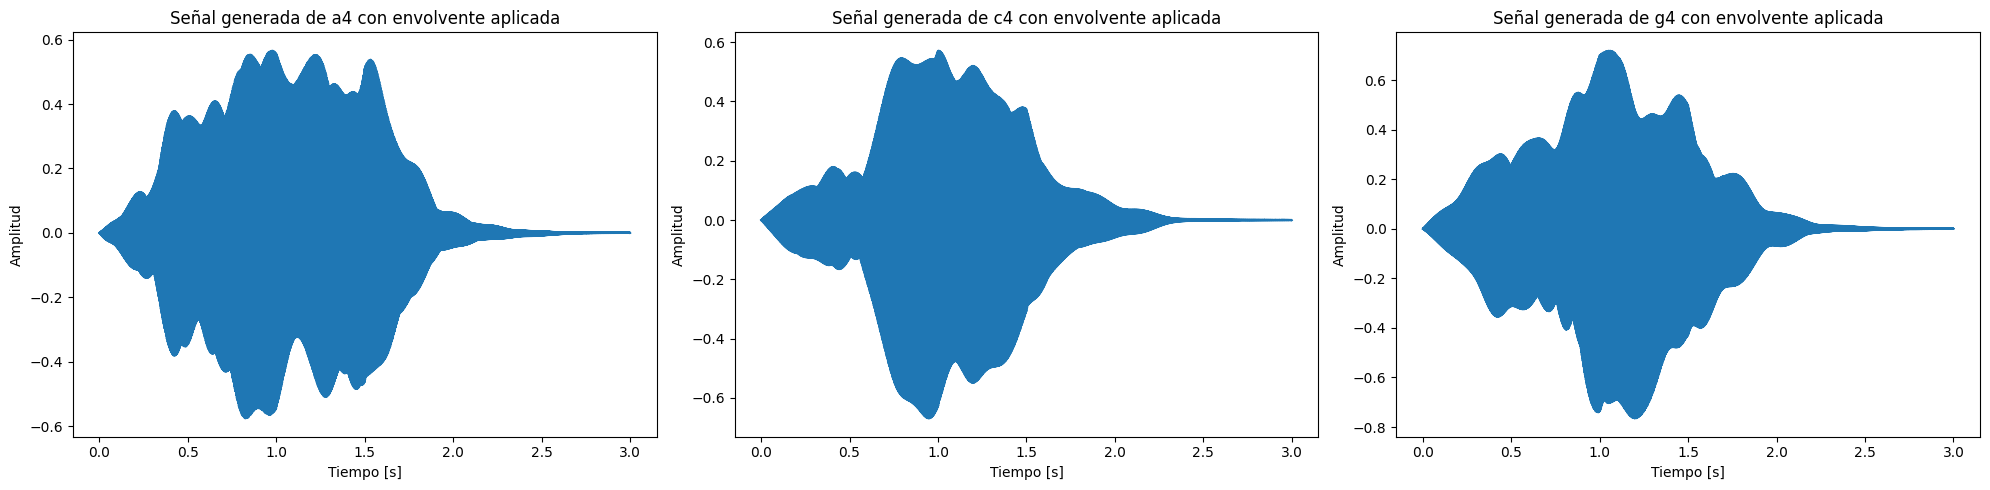

In [8]:
signal_env = {}

# Aplicar la envolvente
for n in notas:
  signal_env[n] = signal[n] * envolvente

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, nota in enumerate(notas):
    axs[i].plot(t, signal_env[nota])
    axs[i].set_title(f'Señal generada de {nota} con envolvente aplicada')
    axs[i].set_xlabel('Tiempo [s]')
    axs[i].set_ylabel('Amplitud')

plt.tight_layout()
plt.show()

# Normalizar y guardar las muestras
for n in notas:
  signal_env[n] = signal_env[n] / np.max(np.abs(signal_env[n]))
  signal_env[n] = (signal_env[n] * 32767).astype(np.int16)
  write(f'violin_generado_{n}.wav', freq_muestreo[n], signal_env[n])

## Conclusión
En este trabajo aplicamos técnicas de procesamiento de señales para descomponer grabaciones de audio de diferentes notas de un violín, para luego poder generarlas artificialmente. Trabajamos con los conceptos de la transformada de Fourier para descomponer las señales de audio en sus componentes de frecuencia y analizar los armónicos más relevantes.
<br>
<br>
En términos generales, este proyecto nos permitió obtener una comprensión más profunda de cómo se construyen los sonidos y cómo podemos manipular y recrear esas señales.

## Referencias


*   Grabaciones obtenidas de https://freesound.org/
*   Caracterizaciones de envolvente ADSR para instrumentos de cuerda frotada: [The bowed string instruments: acoustic characterization of unique pieces from the Italian lutherie](https://www.researchgate.net/publication/325839783_The_bowed_string_instruments_acoustic_characterization_of_unique_pieces_from_the_Italian_lutherie)

